In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from zipfile import ZipFile
from pathlib import Path
from typing import List, Dict
from scipy import stats
from IPython.display import display

In [2]:
track_names = ["f", "fm", "m", "mr", "r"]

In [3]:
def get_data(b_path: Path) -> pd.DataFrame:
    # pre define filter
    rel_cols = {
        "SEAT": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "SEATLOC",
            "SEATTYPE",
            "ORIENTATION",
            "TRACK",
        ],
        "OCC": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "OCCNO",
            "SEATLOC",
            "AGE",
            "HEIGHT",
            "WEIGHT",
            "SEX",
            "ROLE",
            "POSTURE",
            "BELTUSE",
            "CHILDSEATUSE",
            "PREGNANT",
            "OBESITY",
            "BMI",
        ],
        "GV": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "MAKE",
            "MODEL",
            "MODELYR",
            "VEHCLASS",
            "BODYTYPE"
        ],
    }

    # read
    dbs: Dict[str, List[pd.DataFrame]] = defaultdict(list)
    for db_name in rel_cols.keys():
        print(db_name)
        for path in b_path.glob("CISS*.zip"):
            print(path)
            with ZipFile(path) as archive:
                files = {
                    file.filename.split(".")[0]: file.filename
                    for file in archive.filelist
                }

                with archive.open(files[db_name]) as file:
                    dbs[db_name].append(pd.read_csv(file, usecols=rel_cols[db_name]))
                    if db_name == "SEAT":
                        dbs[db_name][-1] = dbs[db_name][-1].dropna()
        dbs[db_name] = pd.concat(dbs[db_name])

    # merge
    full: pd.DataFrame = dbs["OCC"].merge(
        dbs["SEAT"],
        on=["CASEID", "CASENO", "CASENUMBER", "CATEGORY", "PSU", "SEATLOC", "VEHNO"],
    )

    full = full.merge(dbs["GV"],on=["CASEID", "CASENO", "CASENUMBER", "CATEGORY", "PSU", "VEHNO"],)
    return full


data = get_data(b_path=Path("Raw_Data"))
display(data)

SEAT
Raw_Data\CISS_2017_CSV_FILES.zip
Raw_Data\CISS_2018_CSV_files.zip
Raw_Data\CISS_2019_CSV_files.zip
Raw_Data\CISS_2020_CSV_files.zip
Raw_Data\CISS_2021_CSV_files.zip
OCC
Raw_Data\CISS_2017_CSV_FILES.zip
Raw_Data\CISS_2018_CSV_files.zip
Raw_Data\CISS_2019_CSV_files.zip
Raw_Data\CISS_2020_CSV_files.zip
Raw_Data\CISS_2021_CSV_files.zip
GV
Raw_Data\CISS_2017_CSV_FILES.zip
Raw_Data\CISS_2018_CSV_files.zip
Raw_Data\CISS_2019_CSV_files.zip
Raw_Data\CISS_2020_CSV_files.zip
Raw_Data\CISS_2021_CSV_files.zip


,CASEID,PSU,CASENO,CASENUMBER,CATEGORY,VEHNO,OCCNO,SEATLOC,AGE,HEIGHT,...,OBESITY,BMI,SEATTYPE,ORIENTATION,TRACK,MAKE,MODEL,MODELYR,BODYTYPE,VEHCLASS
0,6035,23,1,1-23-2017-001-04,4,1,1,11,77,168,...,NaN,30.8,1.0,1.0,3.0,55,35,2014,4,3
1,6045,17,1,1-17-2017-001-10,10,1,1,11,42,999,...,NaN,99.9,1.0,1.0,2.0,12,13,1998,4,1
2,6045,17,1,1-17-2017-001-10,10,1,2,13,37,999,...,NaN,99.9,1.0,1.0,2.0,12,13,1998,4,1
3,6042,32,1,1-32-2017-001-09,9,1,1,11,25,160,...,1.0,40.6,1.0,1.0,4.0,54,421,2002,15,15
4,6050,13,1,1-13-2017-001-04,4,1,1,11,36,175,...,NaN,29.7,1.0,1.0,6.0,19,18,2016,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29132,21387,22,41,1-22-2021-041-06,6,1,1,11,56,999,...,NaN,99.9,2.0,1.0,5.0,37,31,2012,2,2
29133,22787,15,97,1-15-2021-097-06,6,1,1,11,22,999,...,NaN,99.9,1.0,1.0,9.0,42,42,2013,4,3
29134,23897,29,92,1-29-2021-092-07,7,2,1,11,39,999,...,NaN,99.9,1.0,1.0,5.0,63,402,2012,14,14
29135,23437,26,136,1-26-2021-136-06,6,1,1,11,23,180,...,NaN,23.8,99.0,9.0,9.0,59,34,1999,4,4


In [22]:
def filter_data(db: pd.DataFrame) -> pd.DataFrame:
    db_rel = []
    for cid in db["CASEID"].unique():
        filt = db[db["CASEID"].eq(cid)].copy()

        filt = filt[filt["AGE"].ge(18)] # anly adult occupants
        filt = filt[filt["TRACK"].between(2,6)] # only adjustable seats in known length position
        filt = filt[filt["SEATLOC"].eq(11) | filt["SEATLOC"].eq(13)] # only seats front-left and front-right
        filt = filt[filt["POSTURE"].eq(0)] # only normal posture
        filt = filt[filt["MODEL"].between(1,397)] # only passenger vehicles
        filt = filt[filt["SEX"].isin([1,2]) | filt["PREGNANT"].eq(0)] # only not pregnant

        # passenger must be in vehicle too
        for veh in filt["VEHNO"].unique():
            filt2 = filt[filt["VEHNO"].eq(veh)]
            if 1 in set(filt2["ROLE"]) and 2 in set(filt2["ROLE"]):
                db_rel.append(filt2.copy())

    db_rel = pd.concat(db_rel).set_index(
        ["CASEID", "PSU", "CASENO", "CASENUMBER", "CATEGORY", "VEHNO", "OCCNO"]
    )

    db_rel["TRACK"] = db_rel["TRACK"].replace({i:track_name for i, track_name in enumerate(track_names, 2)})
    db_rel["YEAR"] = [int(x.split("-")[2]) for x in db_rel.index.get_level_values("CASENUMBER")]

    return db_rel

data_filtered = filter_data(db=data)
display(data_filtered)

SEATLOC  AGE  HEIGHT  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                         
6137   33  1      1-33-2017-001-05 5        1     1           11   72     163   
                                                  2           13   28     173   
6131   22  1      1-22-2017-001-02 2        1     1           11   85     172   
                                                  2           13   82     137   
6112   19  5      1-19-2017-005-03 3        2     1           11   51     160   
...                                                          ...  ...     ...   
21617  59  18     1-59-2021-018-05 5        2     2           13   20     178   
22240  48  45     1-48-2021-045-07 7        1     1           11   40     178   
                                                  2           13   36     183   
20369  13  1      1-13-2021-001-04 4        2     1           11   43     173   
                                                  2           13   39     163   

                                                         WEIGHT  SEX  ROLE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                      
6137   33  1      1-33-2017-001-05 5        1     1          55    2     1   
                                                  2          64    1     2   
6131   22  1      1-22-2017-001-02 2        1     1          86    1     1   
                                                  2          86    2     2   
6112   19  5      1-19-2017-005-03 3        2     1          51    2     1   
...                                                         ...  ...   ...   
21617  59  18     1-59-2021-018-05 5        2     2          77    1     2   
22240  48  45     1-48-2021-045-07 7        1     1          91    1     1   
                                                  2          82    2     2   
20369  13  1      1-13-2021-001-04 4        2     1          79    1     1   
                                                  2          68    2     2   

                                                         POSTURE  BELTUSE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                     
6137   33  1      1-33-2017-001-05 5        1     1            0        0   
                                                  2            0        4   
6131   22  1      1-22-2017-001-02 2        1     1            0        4   
                                                  2            0        4   
6112   19  5      1-19-2017-005-03 3        2     1            0        0   
...                                                          ...      ...   
21617  59  18     1-59-2021-018-05 5        2     2            0        0   
22240  48  45     1-48-2021-045-07 7        1     1            0        4   
                                                  2            0        4   
20369  13  1      1-13-2021-001-04 4        2     1            0        4   
                                                  2            0        4   

                                                         CHILDSEATUSE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                 
6137   33  1      1-33-2017-001-05 5        1     1                 0   
                                                  2                 0   
6131   22  1      1-22-2017-001-02 2        1     1                 0   
                                                  2                 0   
6112   19  5      1-19-2017-005-03 3        2     1                 0   
...                                                               ...   
21617  59  18     1-59-2021-018-05 5        2     2                 0   
22240  48  45     1-48-2021-045-07 7        1     1                 0   
                                                  2                 0   
20369  13  1      1-13-2021-001-04 4        2     1                 0   
                                                  2                 0   

                                    

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler

In [103]:
feature_names = [
    "AGE",
    "BELTUSE",
    "BMI",
    #"VEHCLASS",
    "HEIGHT",
    "OBESITY",
    "ORIENTATION",
    "POSTURE",
    "PREGNANT",
    "SEX",
    "WEIGHT",
]

In [104]:
fi = data_filtered[data_filtered["ROLE"].eq(1)]
X_train, X_test, y_train, y_test = train_test_split(
    fi[feature_names],
    fi["TRACK"],
    test_size=0.33,
    random_state=42,
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(491, 10) (243, 10) (491,) (243,)


In [105]:
pipe = make_pipeline(SimpleImputer(), DecisionTreeClassifier(max_depth=5, min_samples_split=20, min_samples_leaf=10))
pipe.fit(X_train, y_train)

print("Train Set")
print(classification_report(y_train, pipe.predict(X_train), target_names=track_names))
print("Dev Set")
print(classification_report(y_test, pipe.predict(X_test), target_names=track_names))

Train Set
              precision    recall  f1-score   support

           f       0.00      0.00      0.00        31
          fm       0.36      0.29      0.32        82
           m       0.40      0.61      0.48       132
          mr       0.56      0.34      0.42       135
           r       0.41      0.52      0.46       111

    accuracy                           0.42       491
   macro avg       0.35      0.35      0.34       491
weighted avg       0.41      0.42      0.40       491

Dev Set
              precision    recall  f1-score   support

           f       0.00      0.00      0.00         9
          fm       0.17      0.16      0.16        45
           m       0.31      0.43      0.36        69
          mr       0.40      0.25      0.31        68
           r       0.25      0.29      0.27        52

    accuracy                           0.28       243
   macro avg       0.22      0.23      0.22       243
weighted avg       0.28      0.28      0.27       243



c:\Users\plaschkies\Technische Hochschule Ingolstadt\THI-TEAM-OccupantSafety-and-ML - Arbeiten - Arbeiten\Data Utilization\FARS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\plaschkies\Technische Hochschule Ingolstadt\THI-TEAM-OccupantSafety-and-ML - Arbeiten - Arbeiten\Data Utilization\FARS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\plaschkies\Technische Hochschule Ingolstadt\THI-TEAM-OccupantSafety-and-ML - Arbeiten - Arbeiten\Data Utilization\FARS\.venv\Lib\site-packages\

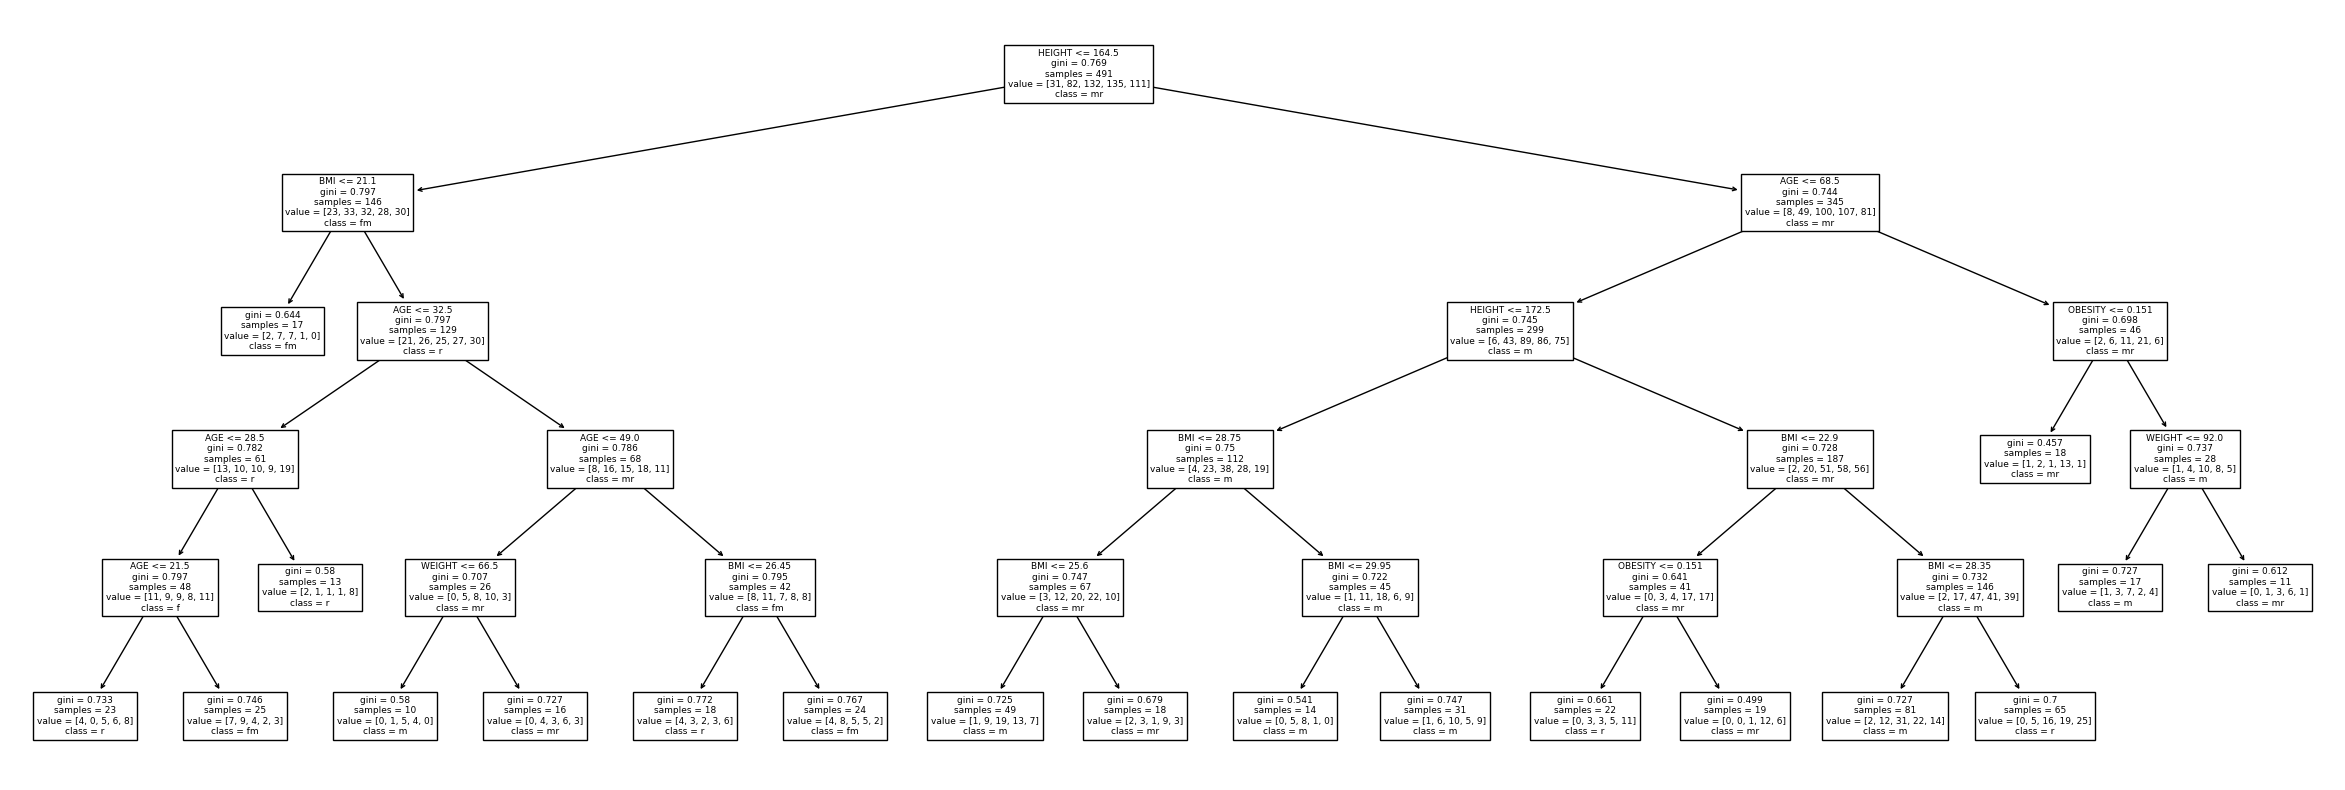

In [106]:
plt.figure(figsize=(30,10))
plot_tree(pipe.named_steps["decisiontreeclassifier"], feature_names=feature_names, class_names=track_names);


<Axes: xlabel='0'>

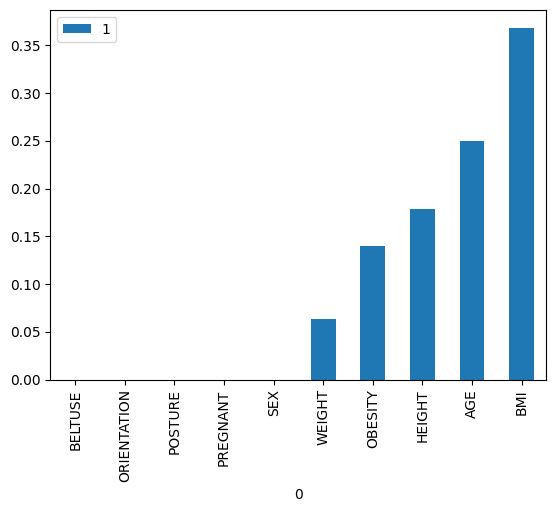

In [107]:
pd.DataFrame(zip(feature_names, pipe.named_steps["decisiontreeclassifier"].feature_importances_)).sort_values(1).plot.bar(x=0, y=1)